# IF3270 Machine Learning | Tugas Besar 2


Group Number: 46

Group Members:
- Ariel Herfrison (13522002)
- Zachary Samuel Tobing (13522016)
- Imam Hanif Mulyarahman (13522030)

## Import Libraries

In [1]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional, TextVectorization
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import os


In [2]:
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
keras.utils.set_random_seed(42)

## Import Dataset

In [3]:
url_train = "https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/train.csv"
train = pd.read_csv(url_train)

url_val = "https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/valid.csv"
val = pd.read_csv(url_val)

url_test = "https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/test.csv"
test = pd.read_csv(url_test)

# Split Training Set and Validation Set

In [4]:
train.head()

,id,text,label
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,positive
2,436,Ibu pernah bekerja di grab indonesia,neutral
3,394,Paling suka banget makan siang di sini ayam sa...,positive
4,592,Pelayanan bus DAMRI sangat baik,positive


In [5]:
val.head()

,id,text,label
0,237,Jika ada pertanyaan lebih lanjut yang ingin ka...,neutral
1,101,Rasanya sih kok harga kaki lima dan rasanya ya...,negative
2,556,"Minimal cek pesan saya, ada problem yang rumit...",neutral
3,474,Dulu restoran ini merupakan favorit saya karen...,negative
4,42,Merupakan resto vintage dengan harga yang cuku...,positive


In [6]:
test.head()

,id,text,label
0,411,"Dekat dengan hotel saya menginap, hanya ditemp...",positive
1,729,"Iya benar, dia sedang jaga warung.",neutral
2,373,Kangkungnya lumayan tapi kepiting saus padangn...,negative
3,262,Bertempat di braga city walk yang satu gedung ...,positive
4,177,Gianyar terima bantuan sosial 2018 sebesar rp ...,neutral


In [7]:
train_df = train.copy()
val_df = val.copy()
test_df = test.copy()

In [8]:
max_len = train_df['text'].apply(lambda x: len(x.split())).max()
print(f"Maximum text length in train: {max_len}")

Maximum text length in train: 77


# Data Cleaning and Preprocessing

In [9]:
# Encoding (pos = 2, neut = 1, neg = 0)
labelEncoder = LabelEncoder()
train_df['label'] = labelEncoder.fit_transform(train_df['label'])
val_df['label'] = labelEncoder.fit_transform(val_df['label'])
test_df['label'] = labelEncoder.fit_transform(test_df['label'])

In [10]:
train_df.head()

,id,text,label
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,1
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,2
2,436,Ibu pernah bekerja di grab indonesia,1
3,394,Paling suka banget makan siang di sini ayam sa...,2
4,592,Pelayanan bus DAMRI sangat baik,2


In [11]:
val_df.head()

,id,text,label
0,237,Jika ada pertanyaan lebih lanjut yang ingin ka...,1
1,101,Rasanya sih kok harga kaki lima dan rasanya ya...,0
2,556,"Minimal cek pesan saya, ada problem yang rumit...",1
3,474,Dulu restoran ini merupakan favorit saya karen...,0
4,42,Merupakan resto vintage dengan harga yang cuku...,2


In [12]:
test_df.head()

,id,text,label
0,411,"Dekat dengan hotel saya menginap, hanya ditemp...",2
1,729,"Iya benar, dia sedang jaga warung.",1
2,373,Kangkungnya lumayan tapi kepiting saus padangn...,0
3,262,Bertempat di braga city walk yang satu gedung ...,2
4,177,Gianyar terima bantuan sosial 2018 sebesar rp ...,1


In [13]:
X_train = np.array(train_df['text'])
y_train = np.array(train_df['label'])

X_val = np.array(val_df['text'])
y_val = np.array(val_df['label'])

X_test = np.array(test_df['text'])
y_test = np.array(test_df['label'])

In [14]:
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Modeling and Validation

In [15]:
max_tokens = 10000 
max_len = 100

vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_len)
vectorize_layer.adapt(X_train)
f1 = F1Score(average='macro')

# Model dengan SimpleRNN
base_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True),
    Bidirectional(SimpleRNN(64, return_sequences=True)),
    Bidirectional(SimpleRNN(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='softmax')
])

# Compile model
base_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

# base_model.summary()

## 4.1 Variasi Jumlah Layer

### 4.1.1 Modeling

#### 4.1.1.1 Model 1 (1 layer simple RNN)

In [16]:
n_layer_1_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(SimpleRNN(16, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_layer_1_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.1.1.2 Model 2 (3 layer simple RNN)

In [17]:
n_layer_2_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(SimpleRNN(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(SimpleRNN(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(SimpleRNN(16)),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_layer_2_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.1.1.3 Model 3 (7 layer simple RNN)

In [18]:
n_layer_3_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(SimpleRNN(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(SimpleRNN(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(SimpleRNN(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(SimpleRNN(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(SimpleRNN(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(SimpleRNN(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(SimpleRNN(16)),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_layer_3_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.1.2. Comparison and Analysis

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - f1_score: 0.3546 - loss: 1.1058 - val_f1_score: 0.3307 - val_loss: 1.0678
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - f1_score: 0.7079 - loss: 0.8785 - val_f1_score: 0.4170 - val_loss: 1.0423
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - f1_score: 0.8334 - loss: 0.7404 - val_f1_score: 0.4745 - val_loss: 1.0306
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - f1_score: 0.9382 - loss: 0.5413 - val_f1_score: 0.5339 - val_loss: 0.9833
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - f1_score: 0.9661 - loss: 0.3591 - val_f1_score: 0.5204 - val_loss: 0.9338
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 223ms/step - f1_score: 0.3982 - loss: 1.1730 - val_f1_score: 0.3536 - val_loss: 1.0561
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - f1_score: 0.6753 - loss: 0.7764 - val_f1_score: 0.4735 - val_loss: 0.9479
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - f1_score: 0.8185 - loss: 0.5599 - val_f1_score: 0.5226 - val_

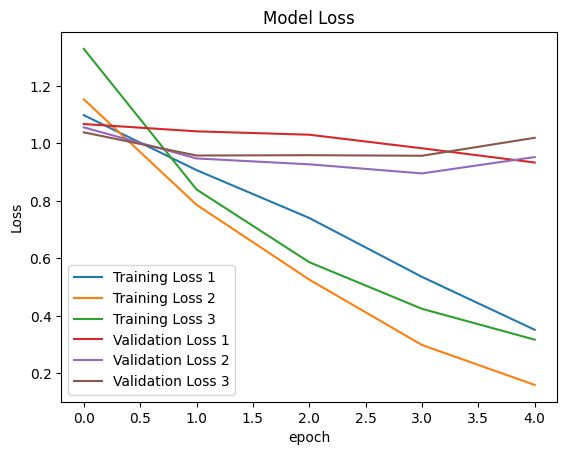

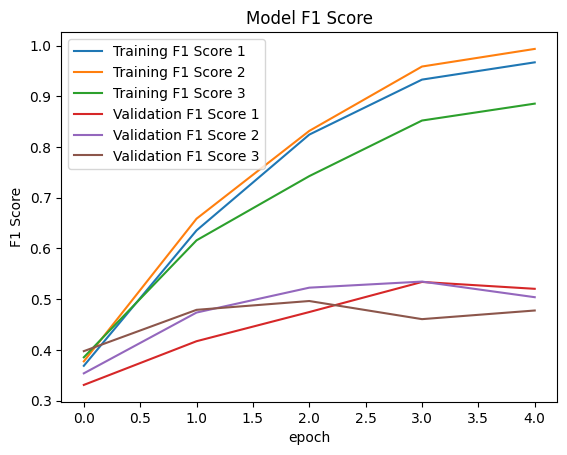

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score: 0.5027 - loss: 0.9860
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - f1_score: 0.5107 - loss: 1.0751
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - f1_score: 0.4867 - loss: 1.0195
Test accuracy 1: 0.5197
Test accuracy 2: 0.5190
Test accuracy 3: 0.5007


In [19]:
history_1 = n_layer_1_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)
history_2 = n_layer_2_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)
history_3 = n_layer_3_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)

plt.plot(history_1.history['loss'], label="Training Loss 1")
plt.plot(history_2.history['loss'], label="Training Loss 2")
plt.plot(history_3.history['loss'], label="Training Loss 3")
plt.plot(history_1.history['val_loss'], label="Validation Loss 1")
plt.plot(history_2.history['val_loss'], label="Validation Loss 2")
plt.plot(history_3.history['val_loss'], label="Validation Loss 3")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(history_1.history['f1_score'], label="Training F1 Score 1")
plt.plot(history_2.history['f1_score'], label="Training F1 Score 2")
plt.plot(history_3.history['f1_score'], label="Training F1 Score 3")
plt.plot(history_1.history['val_f1_score'], label="Validation F1 Score 1")
plt.plot(history_2.history['val_f1_score'], label="Validation F1 Score 2")
plt.plot(history_3.history['val_f1_score'], label="Validation F1 Score 3")
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend()
plt.show()

test_loss_1, test_acc_1 = n_layer_1_model.evaluate(X_test, y_test_cat)
test_loss_2, test_acc_2 = n_layer_2_model.evaluate(X_test, y_test_cat)
test_loss_3, test_acc_3 = n_layer_3_model.evaluate(X_test, y_test_cat)
print(f"Test accuracy 1: {test_acc_1:.4f}")
print(f"Test accuracy 2: {test_acc_2:.4f}")
print(f"Test accuracy 3: {test_acc_3:.4f}")



Peningkatan jumlah layer cenderung meningkatkan performa model dalam menangkap pola yang lebih kompleks. Namun, jumlah layer yang terlalu banyak pada simple RNN dapat menyebabkan risiko overfitting dan masalah vanishing gradient.

## 4.2. Variasi Jumlah Cell

### 4.2.1. Modeling

#### 4.2.1.1 Model 1 (32 cell)

In [20]:
n_cell_1_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(SimpleRNN(32, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_cell_1_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.2.1.2 Model 2 (128 cell)

In [21]:
n_cell_2_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(SimpleRNN(128, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_cell_2_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.2.1.3 Model 3 (512 cell)

In [22]:
n_cell_3_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(SimpleRNN(512, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_cell_3_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

### 4.2.2. Comparison and Analysis

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - f1_score: 0.4403 - loss: 1.0832 - val_f1_score: 0.3671 - val_loss: 1.0356
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - f1_score: 0.7488 - loss: 0.7869 - val_f1_score: 0.5460 - val_loss: 0.9199
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - f1_score: 0.8632 - loss: 0.5788 - val_f1_score: 0.6213 - val_loss: 0.8744
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - f1_score: 0.9622 - loss: 0.3324 - val_f1_score: 0.6522 - val_loss: 0.8225
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - f1_score: 0.9923 - loss: 0.2131 - val_f1_score: 0.6354 - val_loss: 0.8461
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - f1_score: 0.4639 - loss: 1.0624 - val_f1_score: 0.4838 - val_loss: 0.9802
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - f1_score: 0.7943 - loss: 0.7869 - val_f1_score: 0.4818 - val_loss: 0.9379
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - f1_score: 0.9009 - loss: 0.5052 - val_f1_score: 0.3977 - val_los

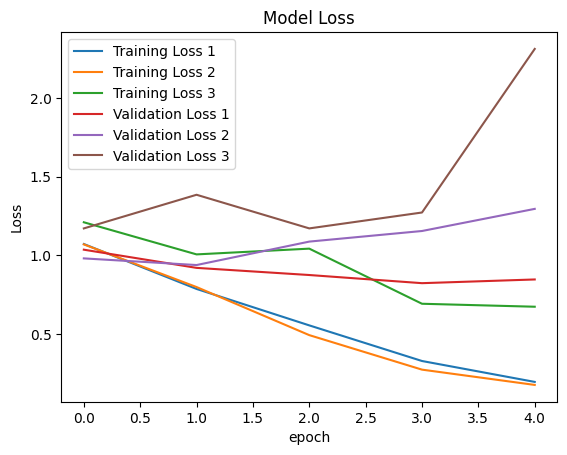

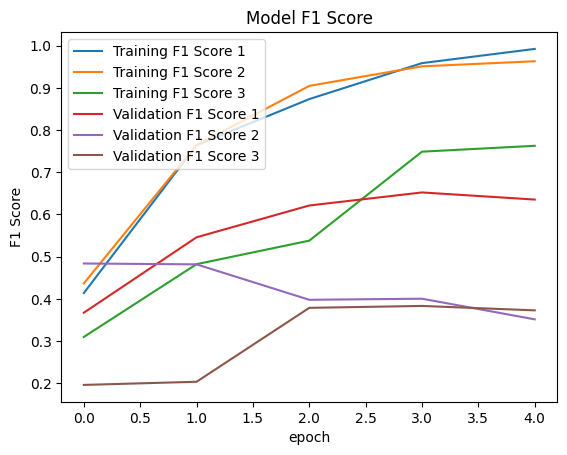

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - f1_score: 0.6012 - loss: 0.7938
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score: 0.3722 - loss: 1.4064
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - f1_score: 0.3235 - loss: 2.2077
Test accuracy 1: 0.6185
Test accuracy 2: 0.3951
Test accuracy 3: 0.3208


In [23]:
history_1 = n_cell_1_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)
history_2 = n_cell_2_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)
history_3 = n_cell_3_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)

plt.plot(history_1.history['loss'], label="Training Loss 1")
plt.plot(history_2.history['loss'], label="Training Loss 2")
plt.plot(history_3.history['loss'], label="Training Loss 3")
plt.plot(history_1.history['val_loss'], label="Validation Loss 1")
plt.plot(history_2.history['val_loss'], label="Validation Loss 2")
plt.plot(history_3.history['val_loss'], label="Validation Loss 3")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(history_1.history['f1_score'], label="Training F1 Score 1")
plt.plot(history_2.history['f1_score'], label="Training F1 Score 2")
plt.plot(history_3.history['f1_score'], label="Training F1 Score 3")
plt.plot(history_1.history['val_f1_score'], label="Validation F1 Score 1")
plt.plot(history_2.history['val_f1_score'], label="Validation F1 Score 2")
plt.plot(history_3.history['val_f1_score'], label="Validation F1 Score 3")
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend()
plt.show()

test_loss_1, test_acc_1 = n_cell_1_model.evaluate(X_test, y_test_cat)
test_loss_2, test_acc_2 = n_cell_2_model.evaluate(X_test, y_test_cat)
test_loss_3, test_acc_3 = n_cell_3_model.evaluate(X_test, y_test_cat)
print(f"Test accuracy 1: {test_acc_1:.4f}")
print(f"Test accuracy 2: {test_acc_2:.4f}")
print(f"Test accuracy 3: {test_acc_3:.4f}")

Peningkatan jumlah cell dapat meningkatkan kemampuan representasi model. Pada suatu titik peningkatan jumlah cell tidak lagi memberikan peningkatan, tetapi kadang justru menurunkan performa. Jumlah cell yang terlalu banyak juga dapat menyebabkan overfitting.

## 4.3. Variasi Arah

### 4.3.1. Modeling

#### 4.3.1.1 Model 1 (Unidirectional)

In [24]:
unidirectional_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True,embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    SimpleRNN(64, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    SimpleRNN(32, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    SimpleRNN(16, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

unidirectional_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.3.1.2 Model 2 (Bidirectional)

In [25]:
bidirectional_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True,embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(keras.layers.SimpleRNN(64, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(keras.layers.SimpleRNN(16, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Dropout(0.5, seed=42),
    keras.layers.Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

bidirectional_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

### 4.3.2. Comparison and Analysis

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - f1_score: 0.3294 - loss: 1.2225 - val_f1_score: 0.3051 - val_loss: 1.0779
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - f1_score: 0.6356 - loss: 0.7825 - val_f1_score: 0.4136 - val_loss: 1.0217
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - f1_score: 0.8018 - loss: 0.5648 - val_f1_score: 0.5183 - val_loss: 0.9696
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - f1_score: 0.9068 - loss: 0.3851 - val_f1_score: 0.5155 - val_loss: 1.0141
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - f1_score: 0.9613 - loss: 0.2229 - val_f1_score: 0.4527 - val_loss: 1.0938
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 228ms/step - f1_score: 0.3751 - loss: 1.2052 - val_f1_score: 0.4585 - val_loss: 1.0534
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - f1_score: 0.7311 - loss: 0.6808 - val_f1_score: 0.4504 - val_loss: 0.9937
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - f1_score: 0.8863 - loss: 0.4214 - val_f1_score: 0.5116 - val

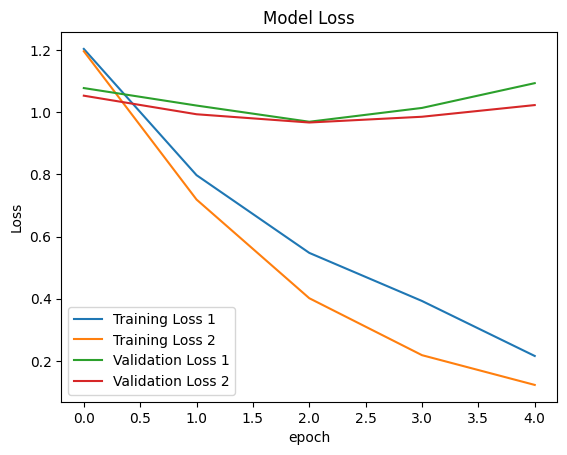

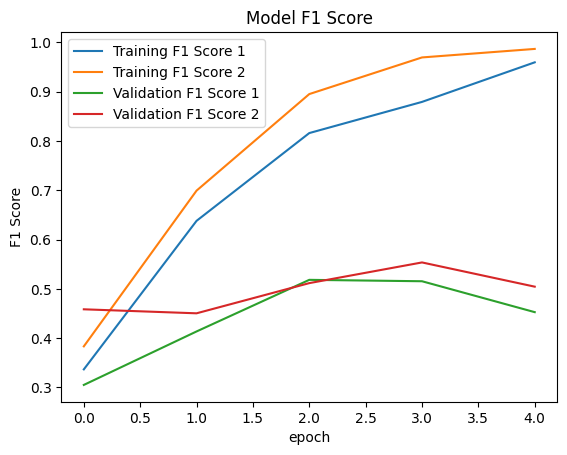

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - f1_score: 0.5123 - loss: 1.1250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - f1_score: 0.4968 - loss: 1.0518
Test accuracy 1: 0.5068
Test accuracy 2: 0.5127


In [26]:
history_1 = unidirectional_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)
history_2 = bidirectional_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)

plt.plot(history_1.history['loss'], label="Training Loss 1")
plt.plot(history_2.history['loss'], label="Training Loss 2")
plt.plot(history_1.history['val_loss'], label="Validation Loss 1")
plt.plot(history_2.history['val_loss'], label="Validation Loss 2")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(history_1.history['f1_score'], label="Training F1 Score 1")
plt.plot(history_2.history['f1_score'], label="Training F1 Score 2")
plt.plot(history_1.history['val_f1_score'], label="Validation F1 Score 1")
plt.plot(history_2.history['val_f1_score'], label="Validation F1 Score 2")
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend()
plt.show()

test_loss_1, test_acc_1 = unidirectional_model.evaluate(X_test, y_test_cat)
test_loss_2, test_acc_2 = bidirectional_model.evaluate(X_test, y_test_cat)
print(f"Test accuracy 1: {test_acc_1:.4f}")
print(f"Test accuracy 2: {test_acc_2:.4f}")



Tidak ada perbedaan yang signifikan dari akurasi model yang menggunakan unidirectional layer dan bidirectional layer. Pada kasus ini, RNN dengan bidirectional layer lebih besar akurasinya dibandingkan unidirectional layer karena pemrosesan kalimat cenderung membutuhkan konteks dari kedua sisi, tetapi dapat dilihat bahwa hasilnya tidak terlalu signifikan.

# 5. Model from Scratch

## 5.1. Modeling

In [27]:
import numpy as np

class SimpleRNNScratch:
    def __init__(self, input_dim, n_cell, return_sequences=False):
        self.input_dim = input_dim
        self.n_cell = n_cell
        self.return_sequences = return_sequences
        self.Wx = None  # Weight for input
        self.Wh = None  # Weight for hidden state
        self.b = None   # Bias

    def load_weights(self, layer):
        weights = layer.get_weights()
        self.Wx = weights[0]  # (input_dim, n_cell)
        self.Wh = weights[1]  # (n_cell, n_cell)
        self.b  = weights[2]  # (n_cell,)

    def tanh(self, x): return np.tanh(x)

    def forward(self, input):
        # input shape: (n_input, input_dim)
        h_t = np.zeros((self.n_cell,))
        h_outputs = []

        for x_t in input:
            h_t = self.tanh(np.dot(x_t, self.Wx) + np.dot(h_t, self.Wh) + self.b)
            if self.return_sequences:
                h_outputs.append(h_t.copy())

        if self.return_sequences:
            return np.stack(h_outputs)  # (n_input, n_cell)
        return h_t  # (n_cell,)

In [28]:
class ModelRNNScratch:
    def __init__(self):
        self.layers = []

    def load_model(self, model, input_dim):
        rnn_layers = [layer for layer in model.layers if layer.name.startswith("simple_rnn")]
        prev_units_dim = input_dim

        for layer in rnn_layers:
            rnn = SimpleRNNScratch(input_dim=prev_units_dim, n_cell=layer.units, return_sequences=layer.return_sequences)
            rnn.load_weights(layer)
            self.layers.append(rnn)
            prev_units_dim = layer.units

    def forward(self, x_seq):
        output = x_seq
        for rnn in self.layers:
            output = rnn.forward(output)
        return output

    def predict(self, X_batch):
        return np.stack([self.forward(x_seq) for x_seq in X_batch])


In [29]:
class Dense:
    def __init__(self, weights, bias):
        self.weights = weights
        self.biases = bias

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)
    
    def forward(self, x):
        z = np.dot(x, self.weights) + self.biases
        return self.softmax(z)

In [30]:
class Embedder:
    def __init__(self, weights):
        self.weights = weights

    def forward(self, X_vectorized):
        return self.weights[X_vectorized]

## 5.2. Comparison & Analysis

In [31]:
model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=False, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    keras.layers.SimpleRNN(64, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    keras.layers.SimpleRNN(32, return_sequences=False, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    keras.layers.Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)

model.save_weights("./weight.weights.h5", overwrite=True)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - f1_score: 0.4460 - loss: 1.0768 - val_f1_score: 0.2350 - val_loss: 1.1016
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - f1_score: 0.3681 - loss: 1.0361 - val_f1_score: 0.3332 - val_loss: 1.1878
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - f1_score: 0.3817 - loss: 1.0879 - val_f1_score: 0.2961 - val_loss: 1.1590
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - f1_score: 0.3416 - loss: 1.0282 - val_f1_score: 0.3487 - val_loss: 1.0716
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - f1_score: 0.4359 - loss: 1.0003 - val_f1_score: 0.3664 - val_loss: 1.2135


In [32]:
model_load = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=False, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    keras.layers.SimpleRNN(64, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    keras.layers.SimpleRNN(32, return_sequences=False, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    keras.layers.Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

model_load.build(input_shape=(None, ))

model_load.load_weights("./weight.weights.h5")

In [33]:
rnn_layer = model_load.layers[2]  # asumsi layer ke-3 adalah SimpleRNN
print(rnn_layer.name)
print(rnn_layer.units)

rnn_weights = rnn_layer.get_weights()

Wx = rnn_weights[0]  # (input_dim, n_cell)
Wh = rnn_weights[1]  # (n_cell, n_cell)
b  = rnn_weights[2]  # (n_cell,)

print("Wx (input weights):\n", Wx, "\n")
print("Wh (recurrent weights):\n", Wh, "\n")
print("b (bias):\n", b, "\n")


simple_rnn_24
64
Wx (input weights):
 [[-0.00965009 -0.23045282  0.01279015 ...  0.1348999   0.07729407
   0.14128801]
 [ 0.10774381  0.11207286 -0.10450143 ...  0.15088026 -0.04199007
  -0.0830385 ]
 [-0.00710456 -0.03868111  0.05712338 ...  0.00997577 -0.05087471
   0.01768759]
 ...
 [-0.03453247 -0.11929824  0.09785373 ... -0.18928647  0.12315949
  -0.17708503]
 [ 0.06524182  0.15051807  0.01051562 ... -0.05376689  0.23242638
   0.01706627]
 [ 0.06824806  0.1849935  -0.02806833 ...  0.18075764 -0.0924523
  -0.12545642]] 

Wh (recurrent weights):
 [[-0.13962214 -0.05557856 -0.1392879  ...  0.24092266 -0.0454621
   0.01277366]
 [-0.10791662  0.13175437  0.04028308 ...  0.01930522 -0.30009857
  -0.005025  ]
 [ 0.22917254 -0.14571984 -0.2291398  ...  0.20650342 -0.07233796
   0.03985516]
 ...
 [-0.00492643 -0.11011806 -0.05036252 ... -0.11049464 -0.00164157
  -0.03411703]
 [-0.03161867  0.02692467 -0.13134497 ...  0.10476492 -0.04665279
   0.0914902 ]
 [-0.18198982 -0.02640581  0.107132

In [34]:
X_test_vectorized = vectorize_layer(np.array(X_test))
print(X_test_vectorized)

tf.Tensor(
[[ 243    7  273 ...    0    0    0]
 [ 513  419  528 ...    0    0    0]
 [2163   84   25 ...    0    0    0]
 ...
 [  66   75   13 ...    0    0    0]
 [ 684  130   72 ...    0    0    0]
 [ 117   39  125 ...    0    0    0]], shape=(400, 100), dtype=int64)


In [35]:
embed_layer = model_load.layers[1]
print(embed_layer.name)

embed_weight = embed_layer.get_weights()[0]
print(embed_weight)

embedding_10
[[-0.02375137 -0.0015218   0.02163464 ...  0.03791778 -0.03257791
   0.04700809]
 [ 0.00810357 -0.03080751  0.00504231 ...  0.03073648  0.00096836
  -0.00115291]
 [-0.02435581  0.03515296  0.06256498 ... -0.02906212 -0.00395355
  -0.01369208]
 ...
 [ 0.04691004 -0.03176409 -0.04656125 ... -0.02658039 -0.02269635
   0.01508906]
 [-0.04883511  0.00909425 -0.04008238 ... -0.04232666  0.0442853
  -0.03144752]
 [ 0.01975579 -0.04435251 -0.03969564 ...  0.01015823  0.00402246
   0.04052125]]


In [36]:
dense_layer = model_load.layers[4]
print(dense_layer.name)

dense_weight = dense_layer.get_weights()[0]
print(dense_weight.shape)
print(dense_weight)

dense_bias = dense_layer.get_weights()[1]
print(dense_bias.shape)
print(dense_bias)

dense_11
(32, 3)
[[-0.0151401  -0.415615    0.0305516 ]
 [ 0.24034838 -0.01357272  0.01790339]
 [ 0.00455536 -0.03943487 -0.01977559]
 [ 0.29345867 -0.11702219  0.02287722]
 [ 0.21810494 -0.37034735 -0.1528522 ]
 [-0.02716175  0.08724218  0.06311814]
 [ 0.37782398  0.25441098  0.2605398 ]
 [-0.3464967  -0.13717614  0.25161308]
 [ 0.24207295  0.19678819 -0.30832866]
 [-0.5251197   0.33113003 -0.29275402]
 [-0.13204095  0.21342833 -0.26520944]
 [ 0.12814584 -0.33147287 -0.02788089]
 [-0.2057229  -0.22043462 -0.3164728 ]
 [-0.11001583 -0.37828404  0.24199457]
 [ 0.3262884   0.09630904 -0.19123077]
 [ 0.0887549   0.11106658 -0.13117689]
 [ 0.25794306  0.09031238  0.01665039]
 [ 0.14397497 -0.48133826 -0.03805727]
 [-0.13570714  0.21037914 -0.2591844 ]
 [-0.09749179 -0.06858478  0.40438986]
 [-0.38171327  0.26036862  0.15652621]
 [ 0.27174985  0.22732064  0.19952413]
 [-0.19312365  0.49832433 -0.13475971]
 [ 0.2998892   0.45668787 -0.07559408]
 [ 0.08358506  0.09517632 -0.21751638]
 [-0.396

In [37]:
# Embedder
embedder = Embedder(embed_weight)
embed_result = embedder.forward(X_vectorized=X_test_vectorized)
print(embed_result.shape)
print("Embedder output: \n", embed_result)

(400, 100, 64)
Embedder output: 
 [[[-0.01411481 -0.04838171 -0.04813103 ...  0.03604417  0.03923723
    0.0113835 ]
  [ 0.01450281 -0.04640573 -0.02942178 ... -0.04110055 -0.04534166
    0.0196733 ]
  [-0.00499475 -0.01075163  0.02686966 ... -0.04109208  0.03055421
    0.01624185]
  ...
  [-0.02375137 -0.0015218   0.02163464 ...  0.03791778 -0.03257791
    0.04700809]
  [-0.02375137 -0.0015218   0.02163464 ...  0.03791778 -0.03257791
    0.04700809]
  [-0.02375137 -0.0015218   0.02163464 ...  0.03791778 -0.03257791
    0.04700809]]

 [[-0.00505687 -0.04493839 -0.01257272 ... -0.00701446 -0.0425924
    0.02025269]
  [-0.00288677 -0.01547992  0.01674919 ...  0.04580913 -0.00639542
   -0.03981685]
  [ 0.02599767 -0.03206969 -0.02960508 ...  0.04427151  0.00574059
    0.06234973]
  ...
  [-0.02375137 -0.0015218   0.02163464 ...  0.03791778 -0.03257791
    0.04700809]
  [-0.02375137 -0.0015218   0.02163464 ...  0.03791778 -0.03257791
    0.04700809]
  [-0.02375137 -0.0015218   0.02163464 .

In [38]:
# SimpleRNN
scratch = ModelRNNScratch()
scratch.load_model(model_load, embed_result.shape[-1])

simpleRNN_output = scratch.predict(embed_result)
print(simpleRNN_output.shape)
print("Simple RNN output:\n", simpleRNN_output)

(400, 32)
Simple RNN output:
 [[-0.12793201  0.60919216 -0.79122483 ...  0.10526726  0.71683191
   0.83059232]
 [ 0.64369333 -0.95870757  0.79452727 ... -0.51882748 -0.88403117
  -0.95059171]
 [ 0.723656   -0.95491486  0.68231297 ... -0.47921882 -0.62336861
  -0.9105801 ]
 ...
 [ 0.70485304 -0.96268837  0.75477164 ... -0.45171804 -0.81527338
  -0.94507637]
 [-0.56020934  0.96458665 -0.68656887 ...  0.57029873  0.15495898
   0.90713987]
 [ 0.66411593 -0.79073084 -0.45739896 ... -0.24720607  0.54349053
  -0.0546479 ]]


In [39]:
# Dense
dense = Dense(dense_weight, dense_bias)
dense_output = dense.forward(simpleRNN_output)
print(dense_output.shape)
print("Dense output: \n", dense_output)

(400, 3)
Dense output: 
 [[0.2647259  0.46078926 0.27448484]
 [0.1789578  0.26545116 0.55559104]
 [0.14743328 0.32894185 0.52362487]
 ...
 [0.15582259 0.31467938 0.52949802]
 [0.7497777  0.10706563 0.14315666]
 [0.12809744 0.43732589 0.43457667]]


In [40]:
model_pred = model_load.predict(X_test)

print(model_pred.shape)
print(model_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
(400, 3)
[[0.2647265  0.46078908 0.2744845 ]
 [0.17895772 0.26545125 0.55559105]
 [0.1474332  0.3289419  0.52362484]
 ...
 [0.1558226  0.3146793  0.52949804]
 [0.7497777  0.1070656  0.14315663]
 [0.12809743 0.43732595 0.4345766 ]]


In [41]:
from sklearn.metrics import f1_score

model_pred_labeled = np.argmax(model_pred, axis=1)
scratch_pred_labeled = np.argmax(dense_output, axis=1)
y_true = np.argmax(y_test_cat, axis=1) 

In [42]:
f1_model = f1_score(y_true, model_pred_labeled, average='macro')
f1_scratch = f1_score(y_true, scratch_pred_labeled, average='macro')

print(f1_model)
print(f1_scratch)

0.3166499735433647
0.3166499735433647


Model 'from scratch' dan model dari keras menghasilkan nilai prediksi yang hampir sama dan memiliki f1_score yang sama. Dari hal ini, dapat disimpulkan bahwa model Simple RNN 'from scratch' sudah dapat melakukan forward propagation dengan benar